# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
# !pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

# m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from haversine import haversine, Unit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set(style="darkgrid")

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
train = train.drop(columns=['dropoff_datetime'])
train.pickup_datetime =  pd.to_datetime(train.pickup_datetime)
# test.pickup_datetime =  pd.to_datetime(test.pickup_datetime)


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

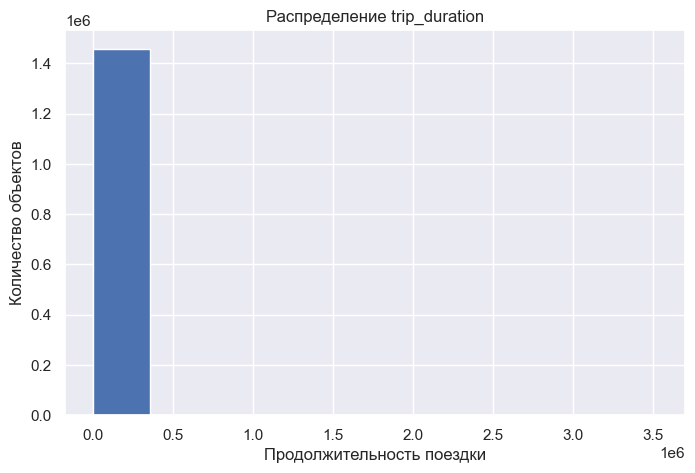

In [6]:
plt.hist(train['trip_duration'])
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество объектов')
plt.title('Распределение trip_duration');

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

C:\Users\egor0\AppData\Local\Temp\ipykernel_19552\734570160.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.log_trip_duration)


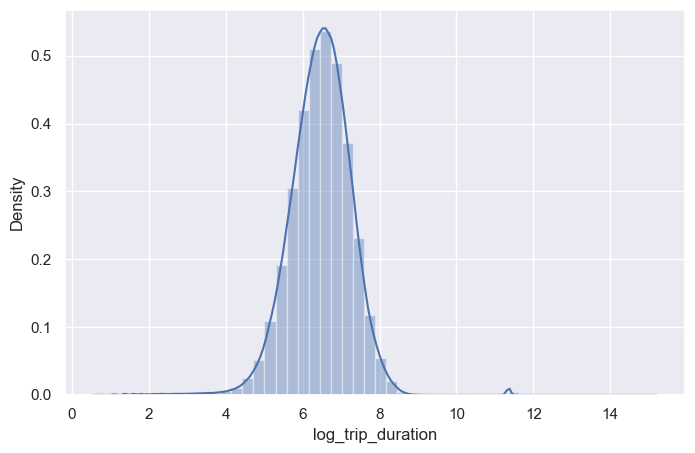

In [7]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])
sns.distplot(train.log_trip_duration)
train = train.drop(columns = ['trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
# Переведем id  в index
train_dummy = train.set_index('id')
# Получим список всех категориальных признаков
get_cat_columns = train_dummy.loc[:,train_dummy.dtypes == np.dtype('object')].columns
print(f'Категориальные признаки: {get_cat_columns.values[0]}')

Категориальные признаки: store_and_fwd_flag


In [9]:
# Разделим выборку на трейн и тест, чтобы предсказать по среднему
(X_train_dummy,
 X_test_dummy,
 y_train_dummy,
 y_test_dummy) = train_test_split(train_dummy.drop('log_trip_duration',axis = 1),
                                  train_dummy['log_trip_duration'],test_size = 0.2,
                                  random_state = 10)

In [10]:
# Выберем стратегию среднего и обучим наш константный регрессор
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_dummy, y_train_dummy)

DummyRegressor()

In [11]:
# Сделаем предсказания
preds_dummy = dummy_regr.predict(X_test_dummy)
# Посчитаем метрику
rmsle_score_dummy = mean_squared_error(y_test_dummy,preds_dummy)
print('RMSLE на константной модели равен:', rmsle_score_dummy.round(4))

RMSLE на константной модели равен: 0.631


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [12]:
day_ride = train.set_index('pickup_datetime').resample('1D').count()['id']

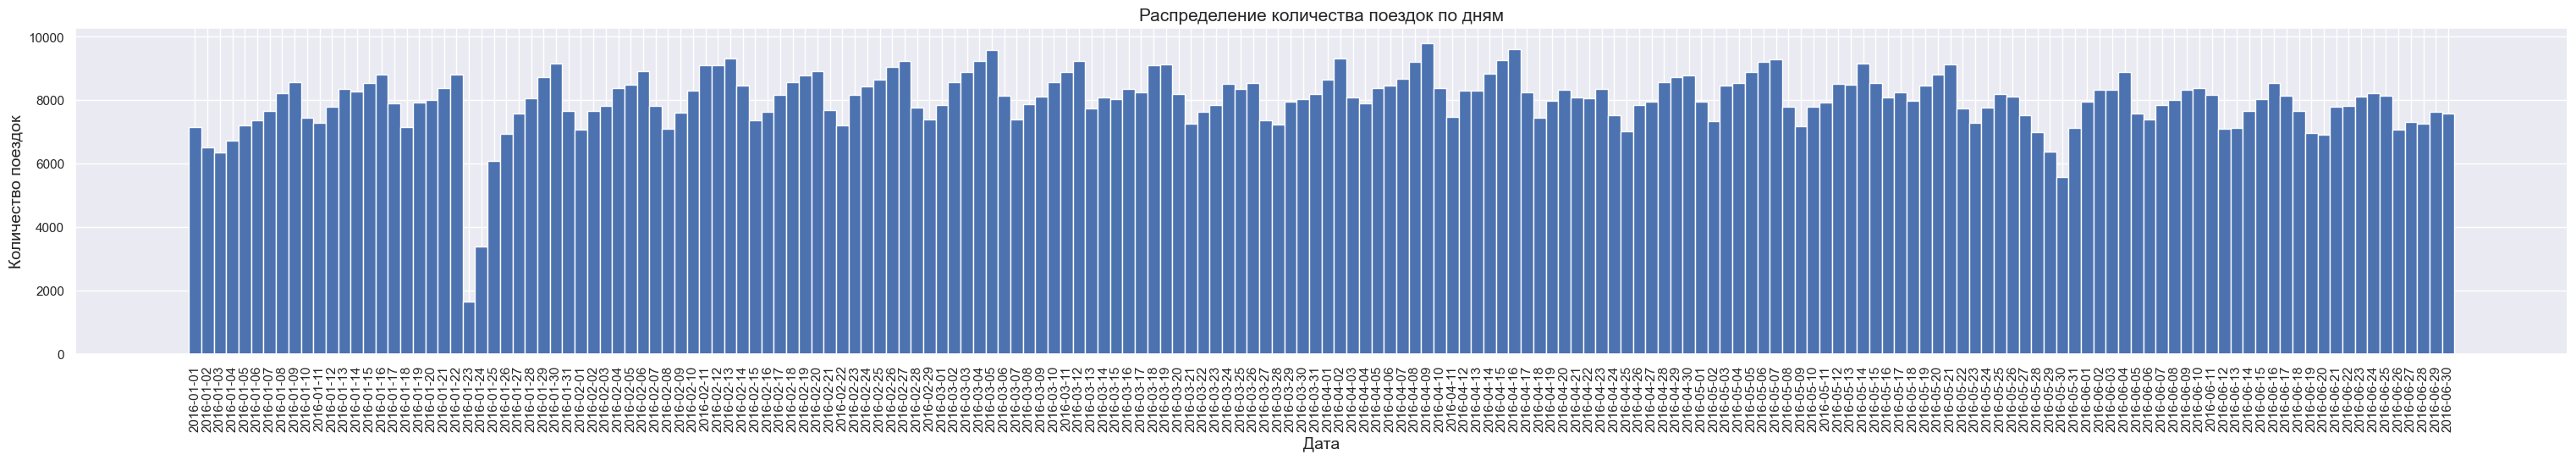

In [13]:
fig,ax = plt.subplots(figsize = (38,5))
ax.bar(day_ride.index.astype('str'), day_ride,width=1)
plt.xlabel('Дата',fontsize = 14)
plt.ylabel('Количество поездок',fontsize = 14)
plt.title('Распределение количества поездок по дням',fontsize = 15)
plt.xticks(rotation=90);

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [14]:
#Разбиваем на часы
day_ride = train.set_index('pickup_datetime').resample('1H').count()['id'].reset_index()
#На каждую неделю
day_ride['day_of_week'] = day_ride['pickup_datetime'].dt.day_name()
#На час в сутках
day_ride['hour'] = day_ride['pickup_datetime'].dt.hour
#На номер месяца
day_ride['month'] = day_ride['pickup_datetime'].dt.month_name()
day_ride = day_ride.set_index('pickup_datetime')

C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


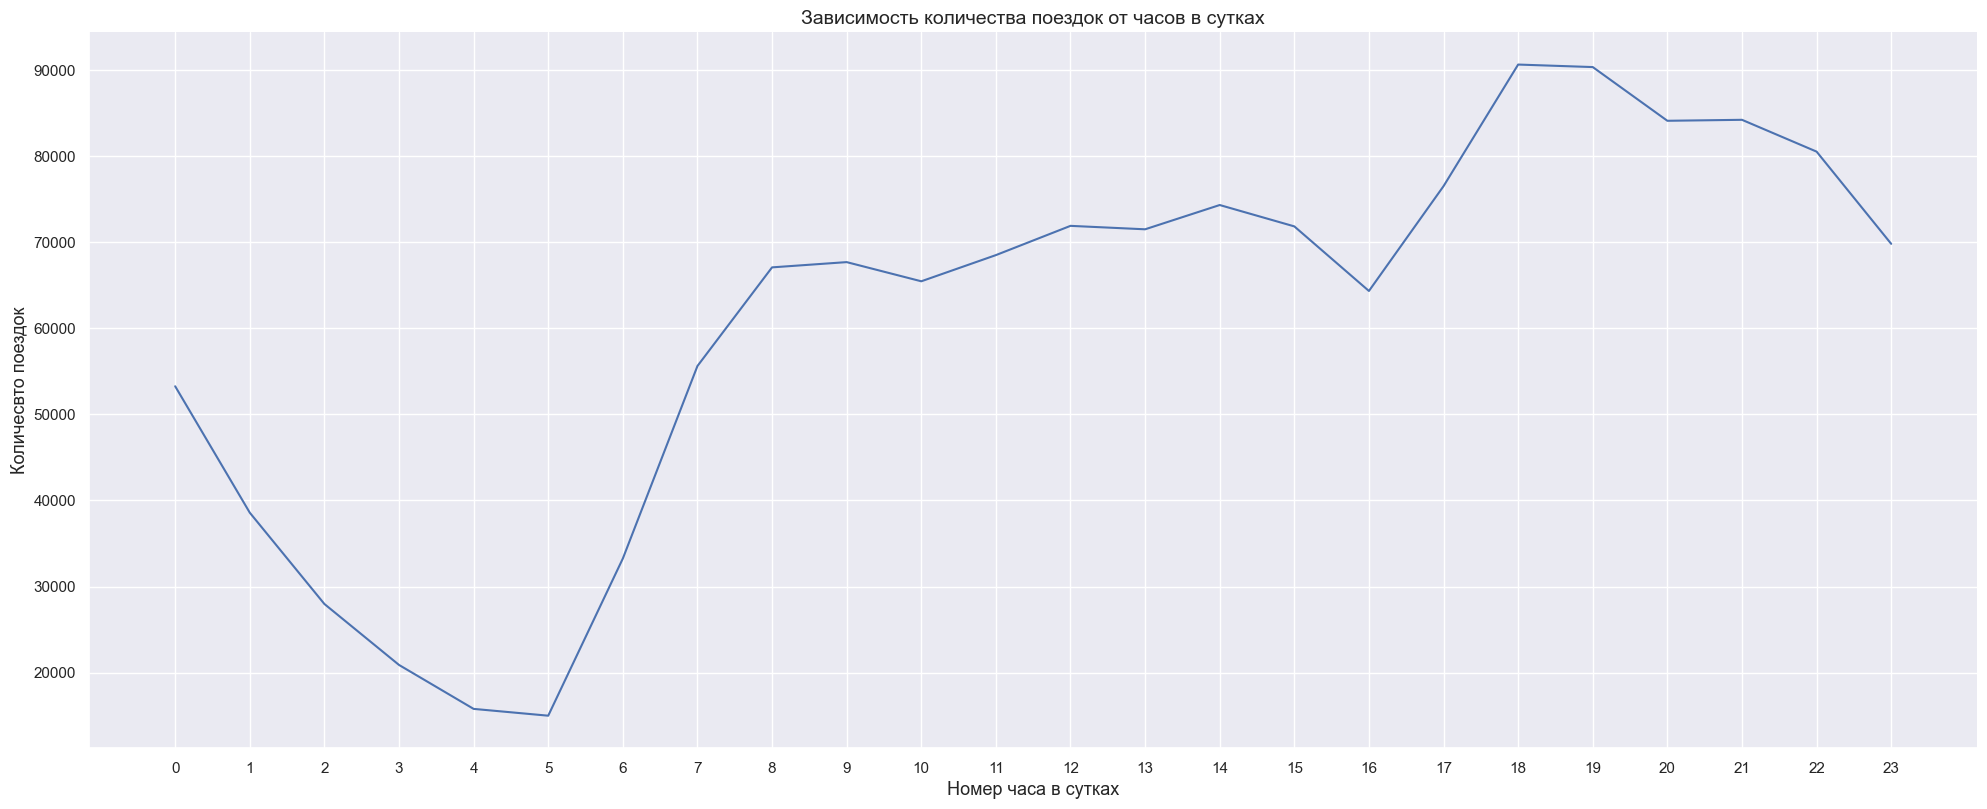

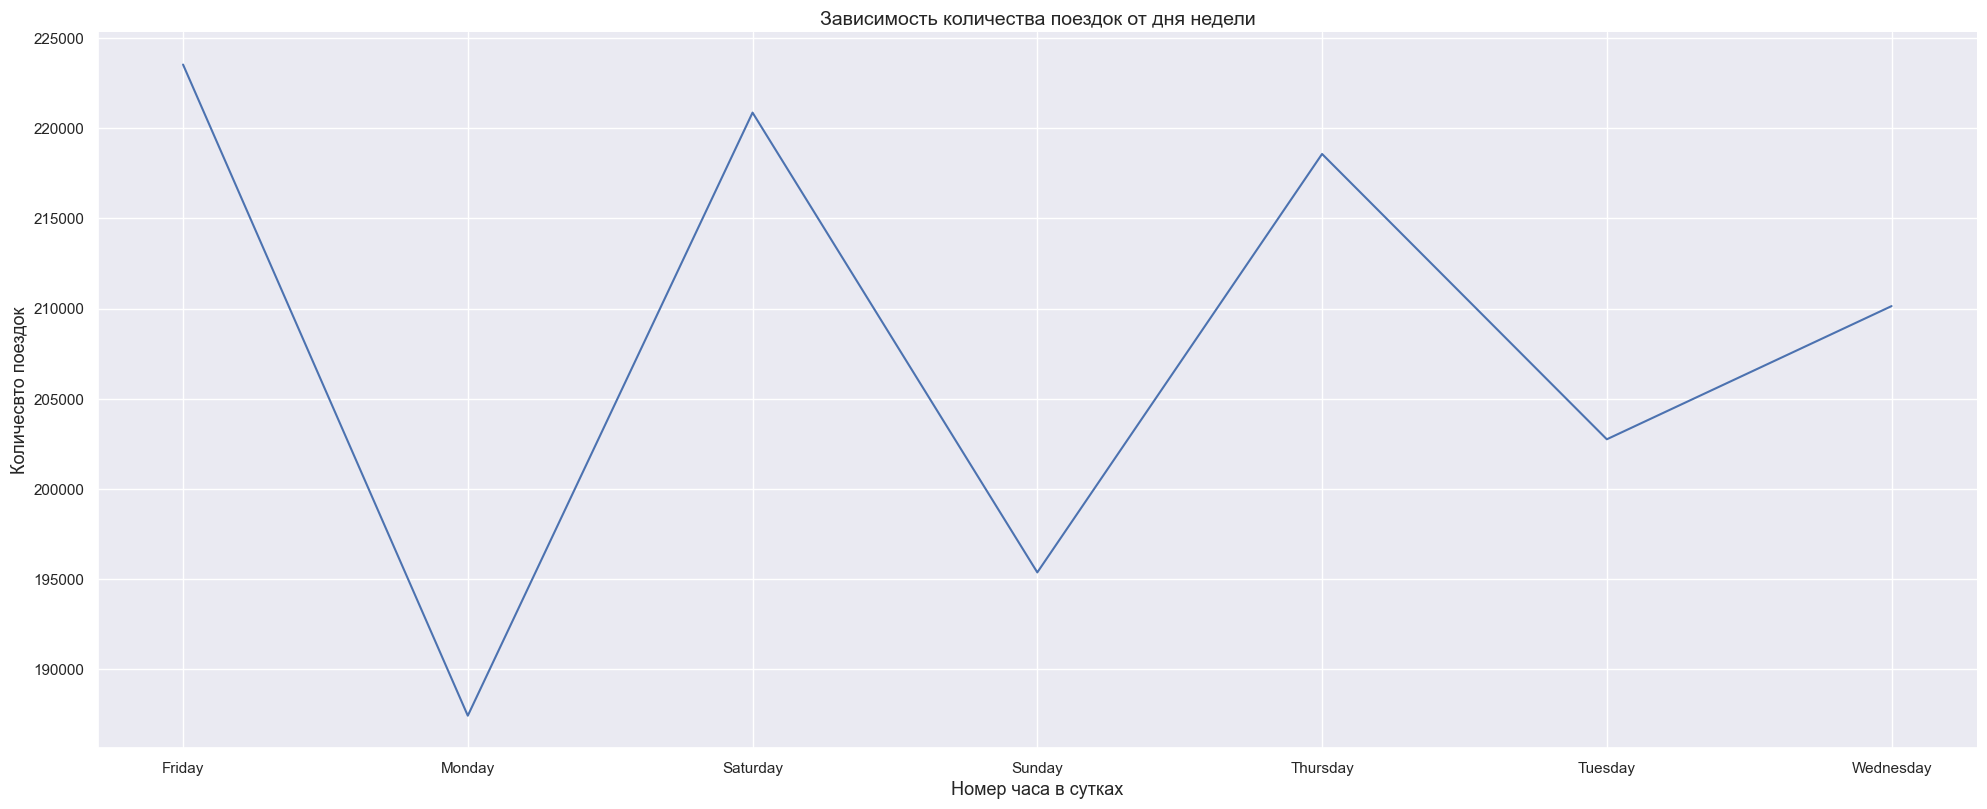

In [15]:
graph_hour = day_ride.groupby(['hour']).sum().reset_index()[['hour', 'id']]
g1 = sns.relplot(data=graph_hour, y='id', x = "hour",kind="line",height=8, aspect=20/8)
g1.set(xticks=range(24))
plt.title('Зависимость количества поездок от часов в сутках',fontsize = 14)
g1.set_xlabels('Номер часа в сутках',fontsize = 13)
g1.set_ylabels('Количесвто поездок',fontsize = 13);
graph_week = day_ride.groupby(['day_of_week']).sum().reset_index()[['day_of_week', 'id']]
g2 = sns.relplot(data=graph_week, y='id', x = "day_of_week",kind="line",height=8, aspect=20/8)
g2.set(xticks=range(7))
plt.title('Зависимость количества поездок от дня недели',fontsize = 14)
g2.set_xlabels('Номер часа в сутках',fontsize = 13)
g2.set_ylabels('Количесвто поездок',fontsize = 13);

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


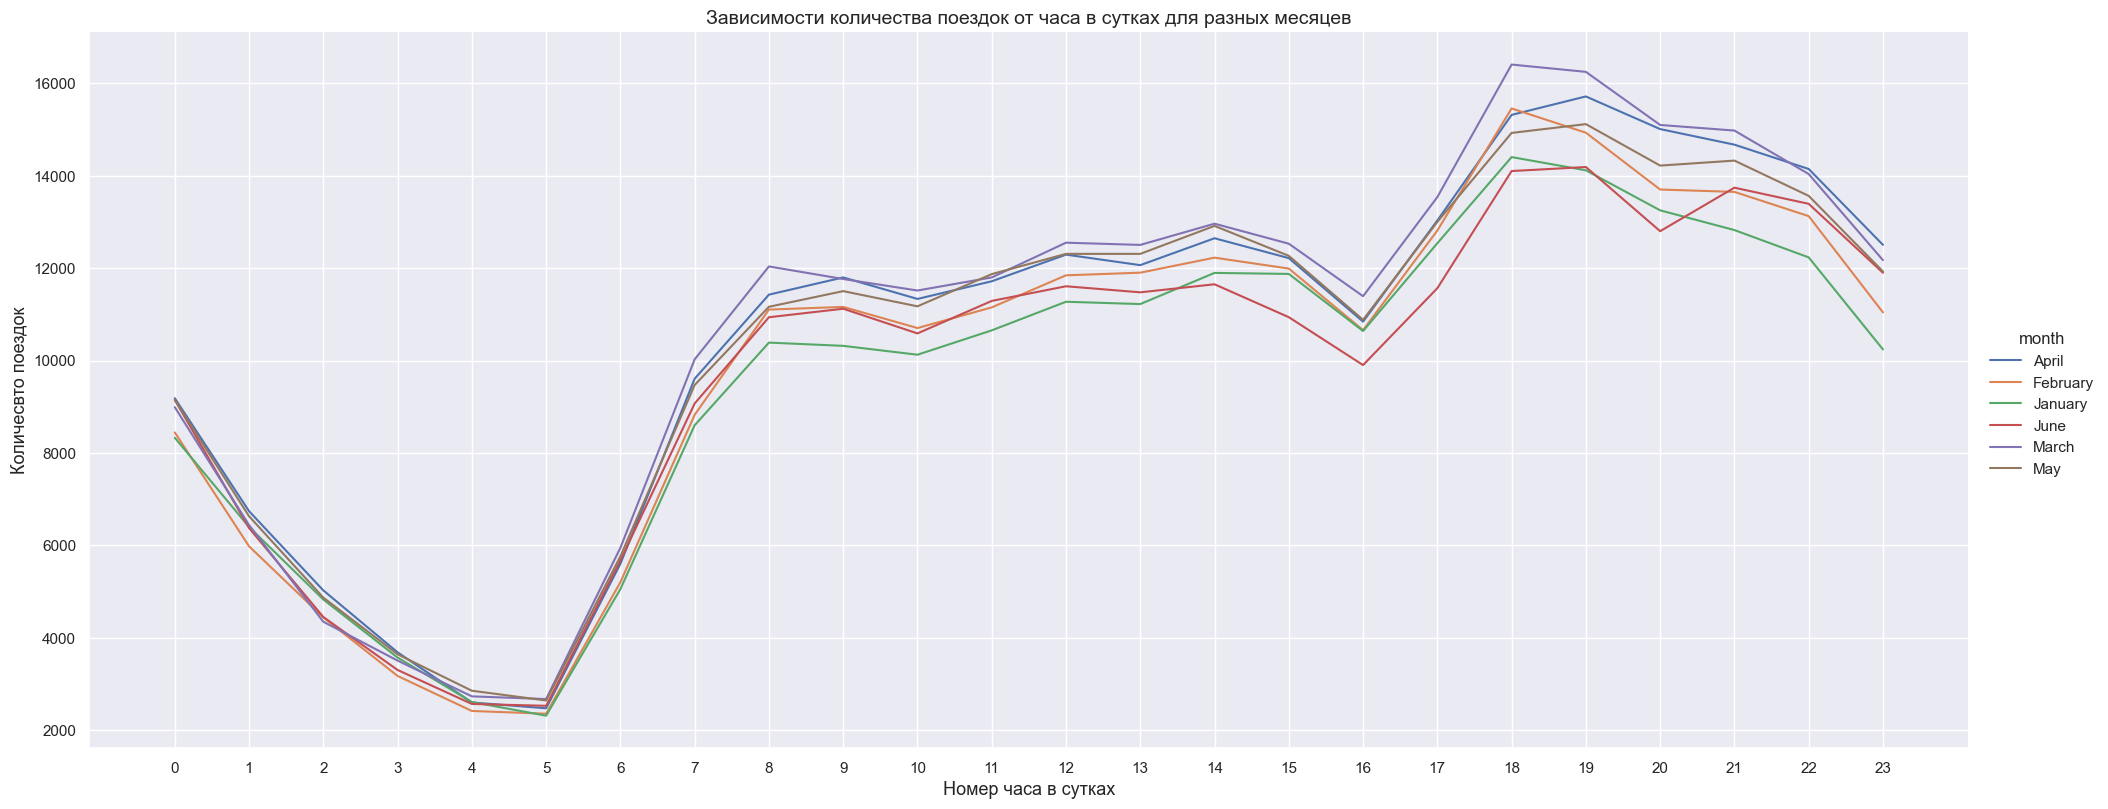

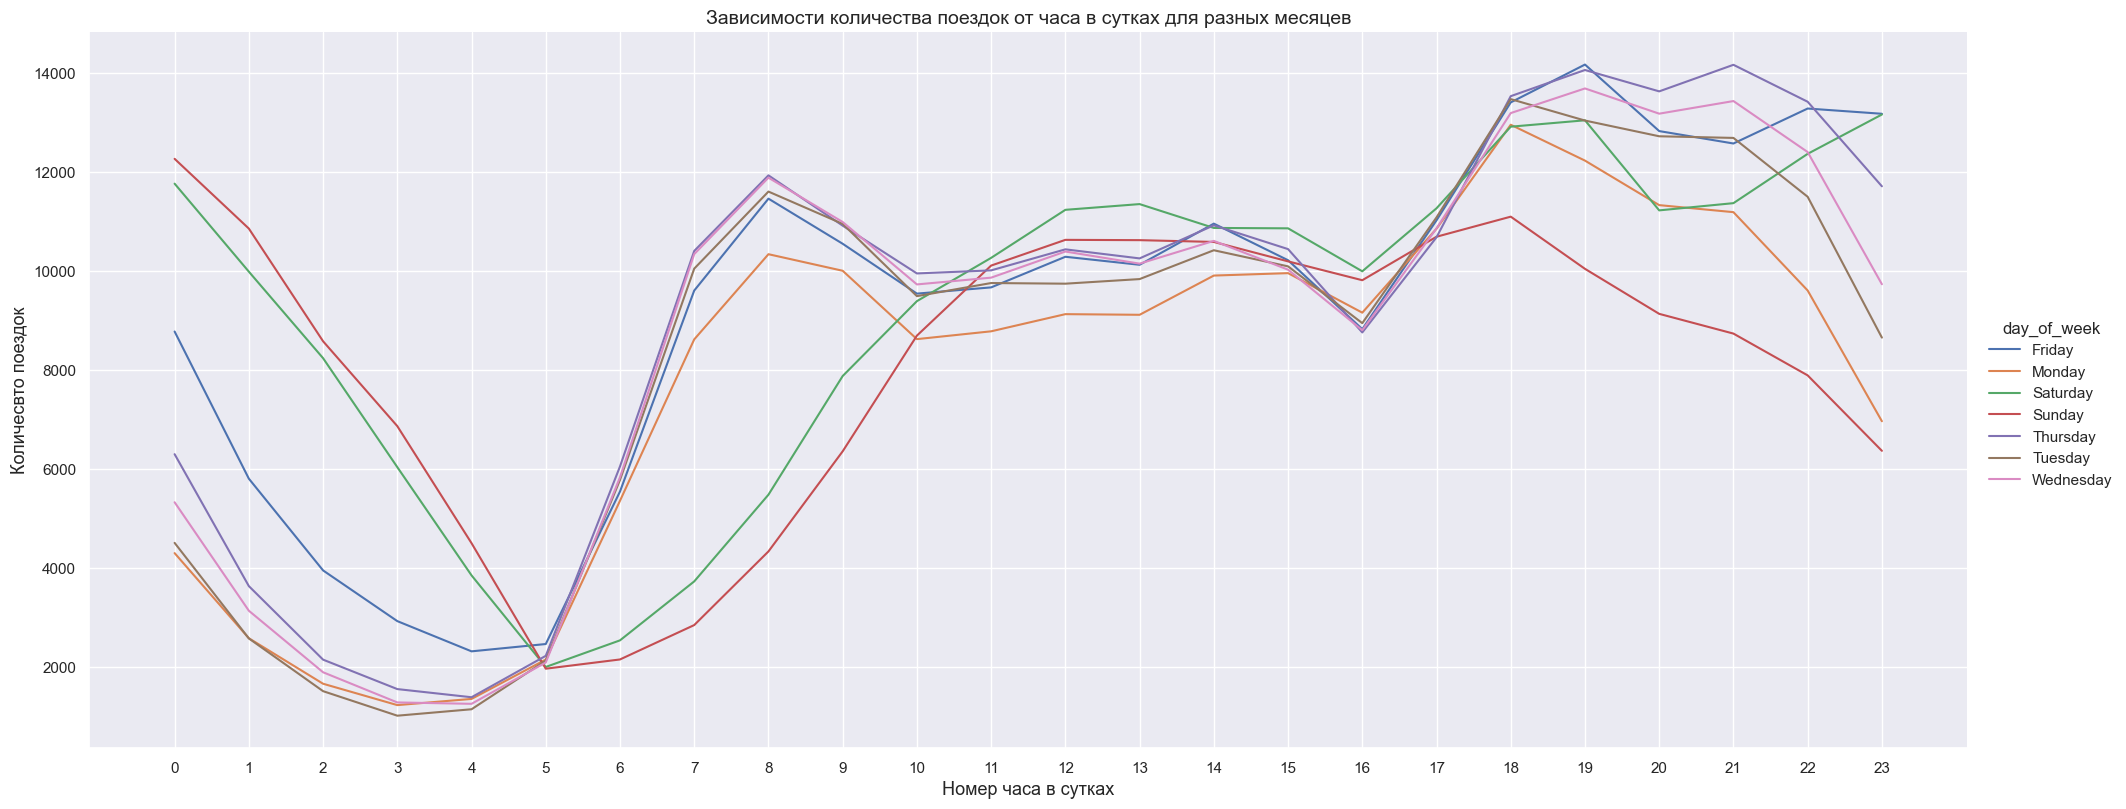

In [16]:
graph_hour_month = day_ride.groupby(['month', 'hour']).sum().reset_index()[['month', 'hour', 'id']]
g3 = sns.relplot(data = graph_hour_month, y='id', x = "hour", hue = 'month', kind="line",height=8, aspect=20/8)
g3.set(xticks=range(24))
plt.title('Зависимости количества поездок от часа в сутках для разных месяцев',fontsize = 14)
g3.set_xlabels('Номер часа в сутках',fontsize = 13)
g3.set_ylabels('Количесвто поездок',fontsize = 13);

graph_hour_weekday = day_ride.groupby(['day_of_week', 'hour']).sum().reset_index()[['day_of_week', 'hour', 'id']]
g4 = sns.relplot(data = graph_hour_weekday, y='id', x = "hour", hue = 'day_of_week', kind="line",height=8, aspect=20/8)
g4.set(xticks=range(24))
plt.title('Зависимости количества поездок от часа в сутках для разных месяцев',fontsize = 14)
g4.set_xlabels('Номер часа в сутках',fontsize = 13)
g4.set_ylabels('Количесвто поездок',fontsize = 13);

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['log_trip_duration']), train['log_trip_duration'], test_size=0.3, random_state=10)

In [18]:
graph_logtime_weekday = X_train.join(y_train)
graph_logtime_weekday['pickup_datetime'] = pd.to_datetime(graph_logtime_weekday['pickup_datetime'])
graph_logtime_weekday['day_of_week'] = graph_logtime_weekday['pickup_datetime'].dt.day_name()
graph_logtime_weekday['hour'] = graph_logtime_weekday['pickup_datetime'].dt.hour

C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


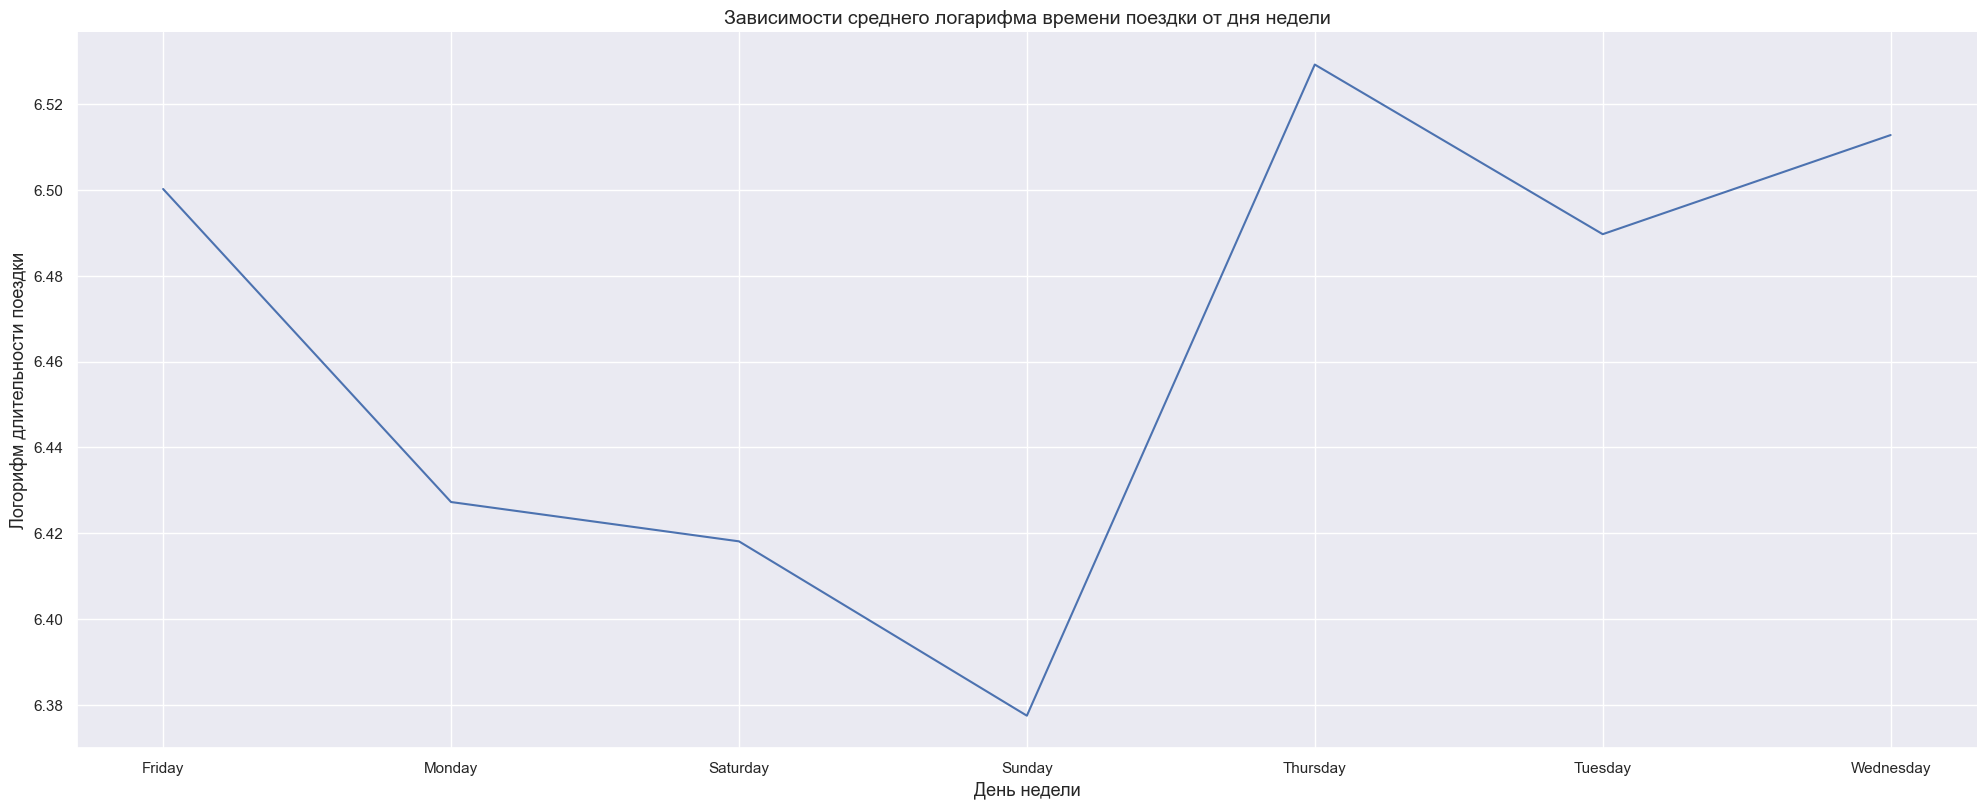

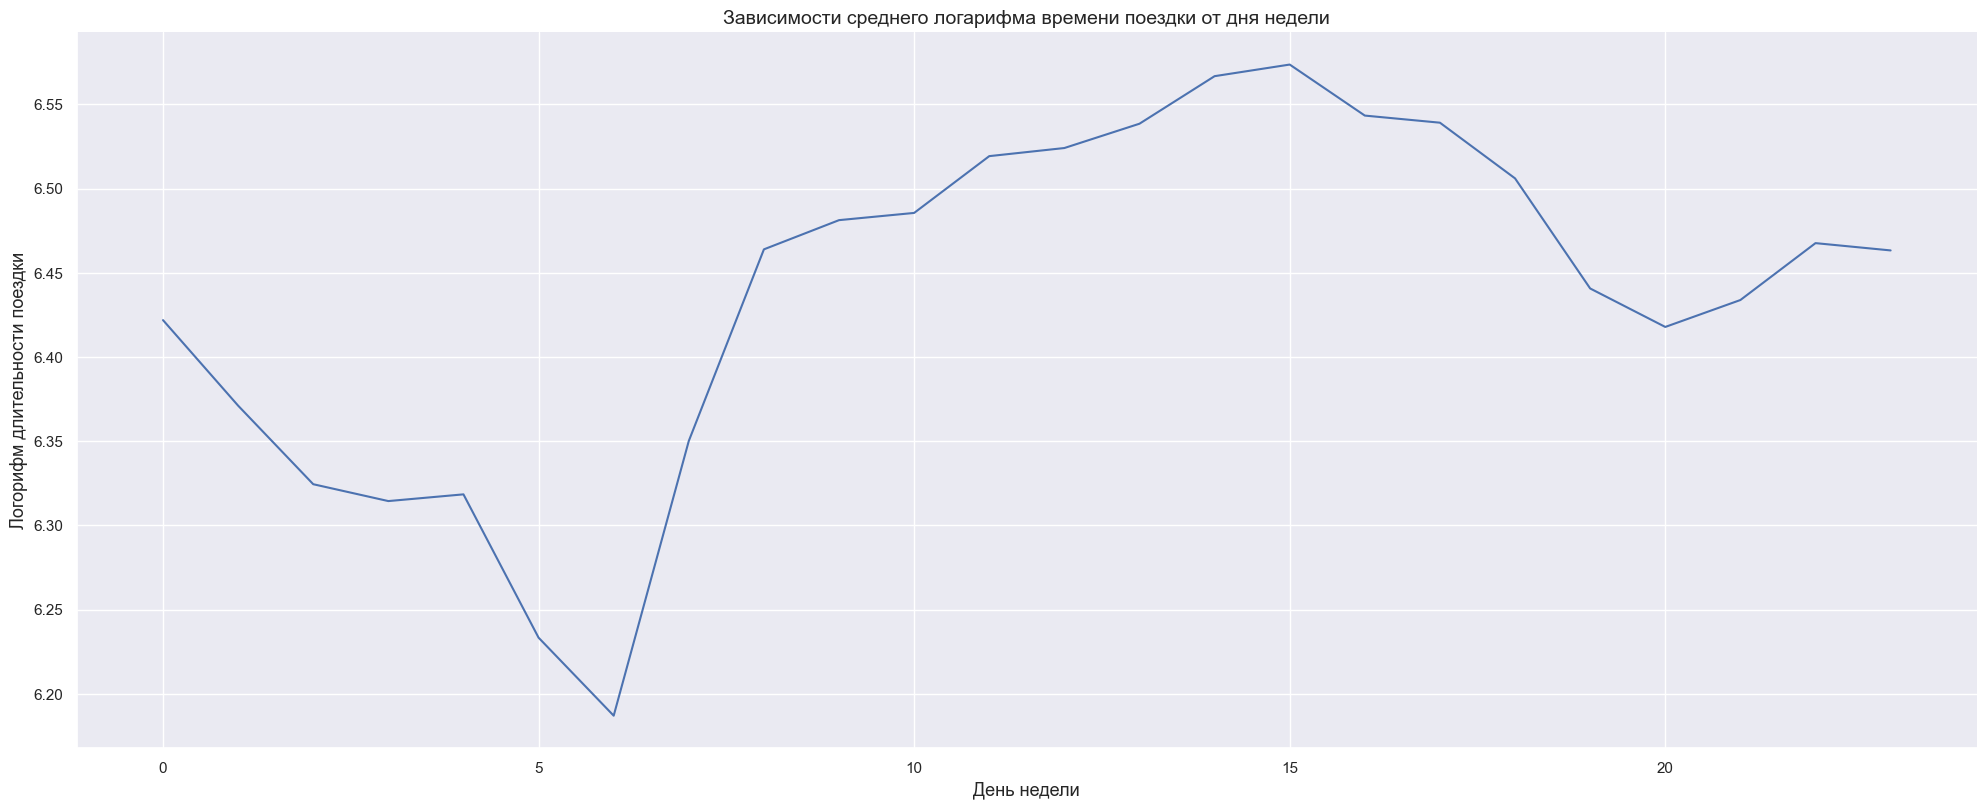

In [19]:
for_fifth_graph = graph_logtime_weekday.groupby('day_of_week').agg({'log_trip_duration': 'mean'}).reset_index()
g5 = sns.relplot(data=for_fifth_graph, y='log_trip_duration', x = "day_of_week",kind="line",height=8, aspect=20/8)
plt.title('Зависимости среднего логарифма времени поездки от дня недели',fontsize = 14)
g5.set_xlabels('День недели',fontsize = 13)
g5.set_ylabels('Логорифм длительности поездки',fontsize = 13);

for_sixth_graph = graph_logtime_weekday.groupby('hour').agg({'log_trip_duration': 'mean'}).reset_index()
g6 = sns.relplot(data=for_sixth_graph, y='log_trip_duration', x = "hour",kind="line",height=8, aspect=20/8)
plt.title('Зависимости среднего логарифма времени поездки от дня недели',fontsize = 14)
g6.set_xlabels('День недели',fontsize = 13)
g6.set_ylabels('Логорифм длительности поездки',fontsize = 13);

C:\Users\egor0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


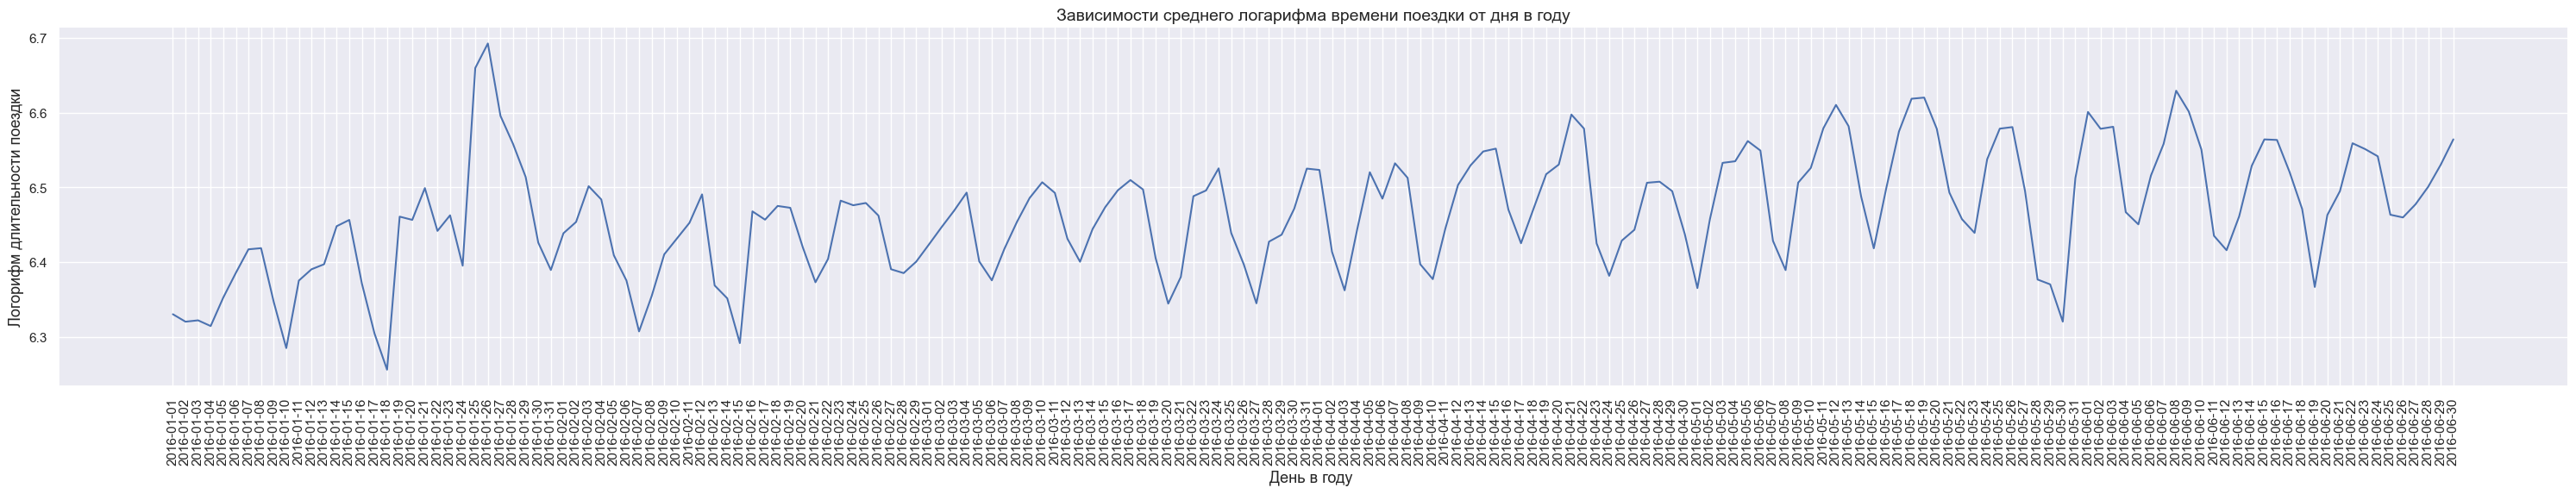

In [20]:
for_seventh_graph = graph_logtime_weekday.set_index('pickup_datetime').resample('1D')['log_trip_duration'].mean().reset_index()
g7 = sns.relplot(data=for_seventh_graph, y=for_seventh_graph['log_trip_duration'], x = for_seventh_graph["pickup_datetime"].astype('str'),kind="line",height=5, aspect=30/5)
plt.title('Зависимости среднего логарифма времени поездки от дня в году',fontsize = 14)
plt.xticks(rotation=90)
g7.set_xlabels('День в году ',fontsize = 13)
g7.set_ylabels('Логорифм длительности поездки',fontsize = 13);

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [21]:
%%time
oulier_zone = pd.to_datetime(['2016-01-23','2016-01-24','2016-01-25','2016-01-26','2016-01-27','2016-05-29','2016-01-30'])

# Добавляем новый признак: название дня недели
train['weekday'] = train['pickup_datetime'].dt.weekday
# Добавляем новый признак: час в сутках
train['hour'] = train['pickup_datetime'].dt.hour
# Добавляем новый признак: номер месяца (для следующего задания)
train['month'] = train['pickup_datetime'].dt.month
# Добавляем новый признак: день в году
train['dayofyear'] = train['pickup_datetime'].dt.dayofyear
# Преобразуем столбец 'pickup_datetime' в тип datetime
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime']).dt.date
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['is_anomaly'] = train['pickup_datetime'].isin(oulier_zone).astype(int)

CPU times: total: 469 ms
Wall time: 648 ms


In [22]:

train.describe()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,weekday,hour,month,dayofyear,is_anomaly
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-03-31 20:03:56.715196160,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,6.466978e+00,3.050375e+00,1.360648e+01,3.516818e+00,9.183607e+01,2.822142e-02
min,1.000000e+00,2016-01-01 00:00:00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.931472e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,2016-02-17 00:00:00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,5.986452e+00,1.000000e+00,9.000000e+00,2.000000e+00,4.800000e+01,0.000000e+00
50%,2.000000e+00,2016-04-01 00:00:00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.496775e+00,3.000000e+00,1.400000e+01,4.000000e+00,9.200000e+01,0.000000e+00
75%,2.000000e+00,2016-05-15 00:00:00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,6.981006e+00,5.000000e+00,1.900000e+01,5.000000e+00,1.360000e+02,0.000000e+00
max,2.000000e+00,2016-06-30 00:00:00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.507575e+01,6.000000e+00,2.300000e+01,6.000000e+00,1.820000e+02,1.000000e+00
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.957595e-01,1.954039e+00,6.399693e+00,1.681038e+00,5.156608e+01,1.656049e-01


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [23]:
# numeric_features = ['log_haversine']
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['log_trip_duration']), train['log_trip_duration'], test_size=0.3, random_state=10)
categorical_features = ['weekday', 'month', 'hour', 'is_anomaly', 'dayofyear']
train_features = ['weekday', 'month', 'hour', 'is_anomaly', 'dayofyear']


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    # ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred,))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.6185
Size before OneHot: (1021050, 14)
Size after OneHot: (1021050, 221)


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [24]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [25]:
# show_circles_on_map(X_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [26]:
# show_circles_on_map(X_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [27]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

X_train.loc[:, 'haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [28]:
train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [29]:
train.loc[:,['log_haversine','haversine','log_trip_duration']].corr()

,log_haversine,haversine,log_trip_duration
log_haversine,1.000000,0.844501,0.749882
haversine,0.844501,1.000000,0.573595
log_trip_duration,0.749882,0.573595,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['log_trip_duration']), train['log_trip_duration'], test_size=0.3, random_state=10)
    

In [31]:
train_speed = pd.Series(X_train['haversine']/((np.exp(y_train) - 1)/3600))

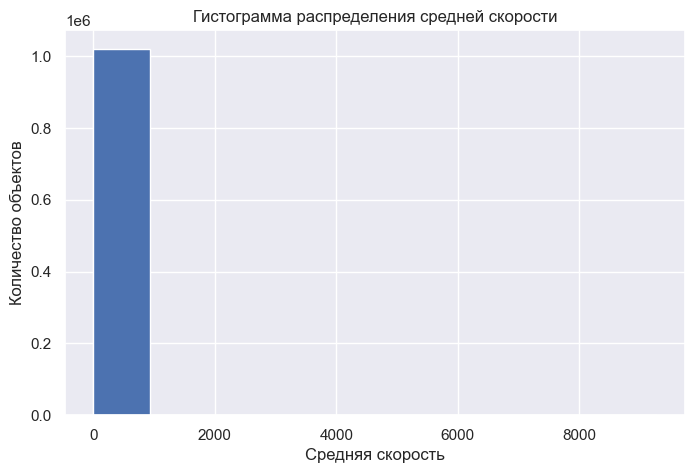

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set(style="darkgrid")
plt.hist(train_speed)
plt.xlabel('Средняя скорость')
plt.ylabel('Количество объектов')
plt.title('Гистограмма распределения средней скорости');

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [33]:
train_speed[train_speed > 120]    

334058      815.991099
467645      833.253493
377068     4086.712020
171801      335.226768
1034044     143.011905
              ...     
491550      155.449836
156328      166.406187
269418      478.884427
656806      197.129135
1359910     564.207216
Length: 92, dtype: float64

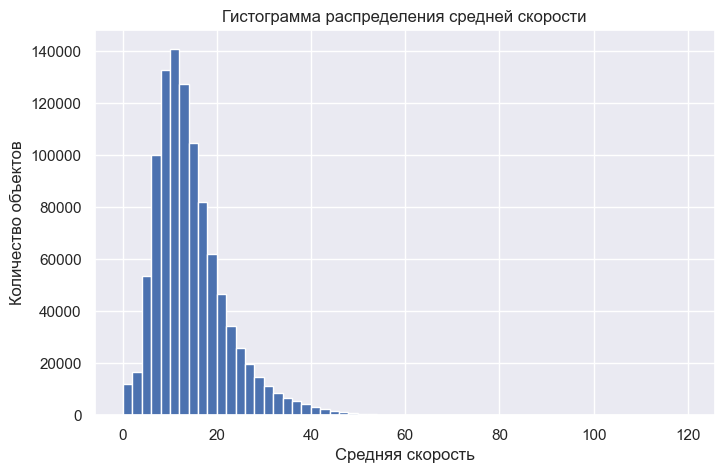

In [34]:
# Гистограмма скорости после очистки
plt.hist(train_speed[train_speed <= 120], bins = 60)
plt.xlabel('Средняя скорость')
plt.ylabel('Количество объектов')
plt.title('Гистограмма распределения средней скорости');

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [35]:
train_speed = pd.DataFrame(train_speed).merge(X_train[['weekday','hour']],left_index=True,right_index=True)
train_speed.columns = ['speed','weekday','hour']
pivot_table_speed = train_speed.pivot_table(index= 'weekday',values = 'speed', columns = 'hour',aggfunc='median')

Text(0.5, 1.0, 'Карта зависисмости скорости от дня недели и часа')

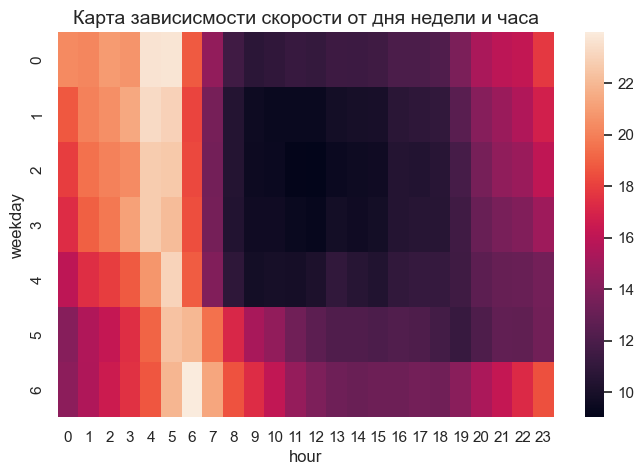

In [36]:
# Построем карту
sns.heatmap(pivot_table_speed)
plt.title('Карта зависисмости скорости от дня недели и часа',fontsize = 14)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [37]:
# X_train.drop(columns = 'speed', inplace = True)
X_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,hour,month,dayofyear,is_anomaly,haversine,log_haversine
824746,id2365163,2,2016-03-27,3,-73.996986,40.742210,-73.987740,40.710659,N,6,0,3,87,0,3.593840,1.524716
645821,id3126187,2,2016-03-18,1,-73.989929,40.741760,-73.977280,40.783600,N,4,20,3,78,0,4.772773,1.753153
691846,id2588127,2,2016-04-15,2,-73.972366,40.750725,-73.861832,40.768387,N,4,18,4,106,0,9.514706,2.352775
1147931,id0915715,2,2016-03-24,1,-73.982361,40.776901,-73.975128,40.760921,N,3,14,3,84,0,1.878364,1.057222
183569,id3758776,1,2016-04-28,1,-73.973778,40.764374,-73.966957,40.761024,N,3,13,4,119,0,0.684609,0.521533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348317,id2763967,1,2016-05-12,1,-73.996178,40.748222,-73.990967,40.755478,N,3,5,5,133,0,0.918456,0.651521
1154171,id0853058,1,2016-01-16,1,-73.995415,40.728886,-73.993706,40.744068,N,5,19,1,16,0,1.694346,0.991155
617841,id2242904,1,2016-03-21,1,-73.960091,40.779701,-73.960136,40.773102,N,0,20,3,81,0,0.733833,0.550334
1048548,id2558617,1,2016-04-09,1,-73.968124,40.799923,-73.952415,40.818588,N,5,9,4,100,0,2.460812,1.241503


**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [38]:
first_zone = (range(9,16),['Tuesday', 'Wednesday','Thursday'])
second_zone = (range(9,13),['Friday'])

train['is_jam'] = ((train['hour'].isin(first_zone[0])) & (train['weekday'].isin(first_zone[1]))) | ((train['hour'].isin(second_zone[0])) & (train['weekday'].isin(second_zone[1])))
train['is_jam'] = train['is_jam'].astype(int)

Задание 8 (0.25 балла). Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [46]:
lat2 = 40.77719879
lon2 = -73.87259674
lat1 = 40.641766
lon1 = -73.780968   

def get_idx_aeroport(X, col_lat, col_lon, lat, lon):
    is_df = (X[[col_lat, col_lon]] - [lat, lon]).abs()
    threshold = 0.005
    selected_rows_1 = is_df[(is_df[col_lat] < threshold) & (is_df[col_lon] < threshold)]
    return selected_rows_1.index


In [48]:
train['is_pickup_k'] = 0
train.loc[get_idx_aeroport(train, 'pickup_latitude', 'pickup_longitude', lat1, lon1), 'is_pickup_k'] = 1
train['is_pickup_g'] = 0
train.loc[get_idx_aeroport(train, 'pickup_latitude', 'pickup_longitude', lat2, lon2), 'is_pickup_g'] = 1

train['is_dropoff_k'] = 0
train.loc[get_idx_aeroport(train, 'dropoff_latitude', 'dropoff_longitude', lat1, lon1), 'is_dropoff_k'] = 1
train['is_dropoff_g'] = 0
train.loc[get_idx_aeroport(train, 'dropoff_latitude', 'dropoff_longitude', lat2, lon2), 'is_dropoff_g'] = 1

# X_test['is_pickup_k'] = 0
# X_test.loc[get_idx_aeroport(X_test, 'pickup_latitude', 'pickup_longitude', lat1, lon1), 'is_pickup_k'] = 1
# X_test['is_pickup_g'] = 0
# X_test.loc[get_idx_aeroport(X_test, 'pickup_latitude', 'pickup_longitude', lat2, lon2), 'is_pickup_g'] = 1

# X_test['is_dropoff_k'] = 0
# X_test.loc[get_idx_aeroport(X_test, 'dropoff_latitude', 'dropoff_longitude', lat1, lon1), 'is_dropoff_k'] = 1
# X_test['is_dropoff_g'] = 0
# X_test.loc[get_idx_aeroport(X_test, 'dropoff_latitude', 'dropoff_longitude', lat2, lon2), 'is_dropoff_g'] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [41]:
# for column in X_train.columns:
#     try:
#         sns.boxplot(x=column, data=X_train)
#         plt.title(column)
#         plt.show()
#     except:
#         print(f"Cannot create a box plot for column: {column}")

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [42]:
%%time

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, start_coods, n_split=4):
        assert len(start_coods) == 4, "start_coods должен быть списком из 4 координат"
        self.n_split = n_split
        self.start_coods = start_coods
        self.pickup_latitude = 'pickup_latitude'
        self.dropoff_latitude = 'dropoff_latitude'
        self.pickup_longitude = 'pickup_longitude'
        self.dropoff_longitude = 'dropoff_longitude'
        self.coords_grid_map = self.split_map()

    def fit(self, X=None, y=None):
        return self

    def split_map(self):
        """
        Метод реализующий деление заданного квадрата на сетку
        """
        # Вычисляем длину одной стороны
        a_side = self.start_coods[0][0] - self.start_coods[3][0]
        b_side = self.start_coods[1][1] - self.start_coods[0][1]
        # Вычисляем длину одной ячейки
        step_by_a_side = a_side / self.n_split
        step_by_b_side = b_side / self.n_split
        coord_pairs = []
        # Задаем стартовую точку
        base_point = self.start_coods[0]
        coord_pairs = []
        # Перебираемся по сетке и запоминаем опорные точки
        # на основе которых потом будем проверять попадание новой точки в зону
        for mult_b in range(1, self.n_split + 1):
            # Вычисляем координаты шага в ширину
            coord_pairs += [((base_point[0], base_point[1] + step_by_b_side),
                             (base_point[0] - step_by_a_side, base_point[1]))]
            for mult_a in range(2, self.n_split + 1):
                # Итеририемся и ишем точки по высоте
                coord_pairs += [((coord_pairs[-1][1][0], coord_pairs[-1][0][1]),
                                 (coord_pairs[-1][1][0] - step_by_a_side, coord_pairs[-1][1][1]))]
            base_point = (base_point[0], base_point[1] + step_by_b_side)
        return coord_pairs

    def transform(self, X, y=None):
        assert all(col in X.columns for col in [self.pickup_latitude, self.dropoff_latitude,
                                                self.pickup_longitude, self.dropoff_longitude]), "Входные данные должны содержать координаты"
        X = X.copy()
        pickup_coords = X[[self.pickup_latitude, self.pickup_longitude]].values
        dropoff_coords = X[[self.dropoff_latitude, self.dropoff_longitude]].values
        pickup_area = np.apply_along_axis(lambda row: self.num_of_area(row), 1, pickup_coords)
        dropoff_area = np.apply_along_axis(lambda row: self.num_of_area(row), 1, dropoff_coords)
        X['pickup_area'] = pickup_area
        X['dropoff_area'] = dropoff_area
        return X

    def num_of_area(self, coords):
        """
        Проверяем точки на вхождение в наши зоны

        """
        for num, coords_points in enumerate(self.coords_grid_map):
            if ((coords_points[1][0] <= coords[0] <= coords_points[0][0]) and
                    (coords_points[1][1] <= coords[1] <= coords_points[0][1])):
                return num
        return -1

CPU times: total: 0 ns
Wall time: 0 ns


In [43]:
# Инициализируем трансформер
first_point = (40.832214, -74.028676)
second_point = (40.832214, -73.923550)
third_point = (40.700761, -73.923550)
fourth_point = (40.700761, -74.028676) 
coord_for_transform = [first_point,second_point,third_point,fourth_point]
train_transform = MapGridTransformer(coord_for_transform)

In [44]:
# Тренируем трансформер 
train_transform.fit()

MapGridTransformer(start_coods=[(40.832214, -74.028676), (40.832214, -73.92355),
                                (40.700761, -73.92355),
                                (40.700761, -74.028676)])

In [49]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'weekday', 'hour', 'month', 'dayofyear', 'is_anomaly', 'haversine',
       'log_haversine', 'is_jam', 'is_pickup_k', 'is_pickup_g', 'is_dropoff_k',
       'is_dropoff_g'],
      dtype='object')

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['log_trip_duration']), train['log_trip_duration'], test_size=0.3, random_state=10)
numeric_features = ['log_haversine']
categorical_features = ['weekday', 'hour',
                         'month', 'dayofyear']
train_features = ['weekday', 'hour', 'month', 'dayofyear', 'is_anomaly',
       'log_haversine', 'is_jam', 'is_pickup_k', 'is_pickup_g',
       'is_dropoff_k', 'is_dropoff_g']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)





Test RMSE = 0.2485
Size before OneHot: (1021050, 21)
Size after OneHot: (1021050, 220)


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
unique_counts = X_train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()
unique_counts

vendor_id             2
passenger_count       9
store_and_fwd_flag    2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [ ]:
# sns.boxplot(x='vendor_id', y = y_train['log_trip_duration'], data=X_train)
# plt.title('vendor_id')
# plt.show()

# sns.boxplot(x='passenger_count', y = y_train['log_trip_duration'], data=X_train)
# plt.title('passenger_count')
# plt.show()

# sns.boxplot(x='store_and_fwd_flag', y = y_train['log_trip_duration'], data=X_train)
# plt.title('store_and_fwd_flag')
# plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [54]:
# X_train['store_and_fwd_flag'] = X_train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})
# X_train['vendor_id'] = X_train['vendor_id'].replace({'1': 0, '2': 1})
# X_test['store_and_fwd_flag'] = X_test['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})
# X_test['vendor_id'] = X_test['vendor_id'].replace({'1': 0, '2': 1})
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})
train['vendor_id'] = train['vendor_id'].replace({'1': 0, '2': 1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns = ['log_trip_duration']), train['log_trip_duration'], test_size=0.3, random_state=10)
numeric_features = ['log_haversine']
categorical_features = ['weekday', 'hour',
                         'month', 'dayofyear', 'passenger_count']
train_features = ['weekday', 'hour', 'month', 'dayofyear', 'is_anomaly',
       'log_haversine', 'is_jam', 'is_pickup_k', 'is_pickup_g',
       'is_dropoff_k', 'is_dropoff_g', 'passenger_count', 'vendor_id', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.2482
Size before OneHot: (1021050, 21)
Size after OneHot: (1021050, 229)


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [60]:
train = train.drop(columns = ['vendor_id', 'passenger_count','store_and_fwd_flag'])

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
# sns.histplot(X_train.log_haversine, kde = True)
# plt.show()

In [61]:
# Нахождение квантиля
quantile_value_max = X_train['log_haversine'].quantile(0.75)
quantile_value_min = X_train['log_haversine'].quantile(0.25)
iqr = quantile_value_max - quantile_value_min
lower_bound = quantile_value_min - 1.5 * iqr
upper_bound = quantile_value_max + 1.5 * iqr
# Фильтрация данных и удаление строк, основываясь на квантиле
X_train = X_train[(lower_bound < X_train['log_haversine']) & (X_train['log_haversine'] < upper_bound)]

# sns.histplot(X_train.log_haversine, kde = True)
plt.show()


In [62]:
y_train = y_train[y_train.index.isin(X_train.index)]
# display(X_train.shape, y_train.shape)

In [ ]:
# sns.histplot(y_train.log_trip_duration, kde = True)
# plt.show()

In [64]:
# Нахождение квантиля
quantile_value_max = y_train.quantile(0.75)
quantile_value_min = y_train.quantile(0.25)
iqr = quantile_value_max - quantile_value_min
lower_bound = quantile_value_min - 1.5 * iqr
upper_bound = quantile_value_max + 1.5 * iqr
# Фильтрация данных и удаление строк, основываясь на квантиле
y_train = y_train[(lower_bound < y_train) & (y_train < upper_bound)]

# sns.histplot(y_train.log_trip_duration, kde = True)
plt.show()


In [65]:
X_train = X_train[X_train.index.isin(y_train.index)]
# display(X_train.shape, y_train.shape)

In [66]:
y_train_pred = model.predict(X_train[train_features])
reg_residuals = pd.Series(np.array(y_train_pred)-y_train, name='reg_residuals')
# sns.histplot(reg_residuals)
# plt.show()

In [69]:
y_train = y_train[y_train.index.isin(X_train.index)]
display(X_train.shape, y_train.shape)

(975508, 21)

(975508,)

In [70]:
# Нахождение квантиля
quantile_value_max = reg_residuals.quantile(0.75)
quantile_value_min = reg_residuals.quantile(0.25)
iqr = quantile_value_max - quantile_value_min
lower_bound = quantile_value_min - 1.5 * iqr
upper_bound = quantile_value_max + 1.5 * iqr
# Фильтрация данных и удаление строк, основываясь на квантиле
reg_residuals = reg_residuals[(lower_bound < reg_residuals) & (reg_residuals < upper_bound)]

# sns.histplot(reg_residuals, kde = True)
# plt.show()


In [71]:
reg_residuals.shape

(957558,)

In [72]:
X_train = X_train[X_train.index.isin(reg_residuals.index)]
y_train = y_train[y_train.index.isin(reg_residuals.index)]
display(reg_residuals.shape, X_train.shape, y_train.shape)

(957558,)

(957558, 21)

(957558,)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [73]:
X_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'weekday', 'hour', 'month',
       'dayofyear', 'is_anomaly', 'haversine', 'log_haversine', 'is_jam',
       'is_pickup_k', 'is_pickup_g', 'is_dropoff_k', 'is_dropoff_g'],
      dtype='object')

In [74]:
cols = ["is_pickup_k","is_pickup_g","is_dropoff_k", 'is_dropoff_g']
X_train = X_train.eval("airports = 0+(0!=(is_pickup_k + is_pickup_g + is_dropoff_k + is_dropoff_g))").drop(columns=cols)
X_test = X_test.eval("airports = 0+(0!=(is_pickup_k + is_pickup_g + is_dropoff_k + is_dropoff_g))").drop(columns=cols)

In [75]:
# # Создаем новый столбец 'jam_free' и заполняем его значениями 0 по умолчанию
# X_train['jam_free'] = 0
# X_test['jam_free'] = 0
#  # Заменяем значения столбца 'jam_free' в соответствии с условиями
# X_train.loc[X_train['is_jam'] == 1, 'jam_free'] = 1
# X_train.loc[X_train['is_free'] == 1, 'jam_free'] = 2

# X_test.loc[X_test['is_jam'] == 1, 'jam_free'] = 1
# X_test.loc[X_test['is_free'] == 1, 'jam_free'] = 2

KeyError: 'is_free'

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [86]:
numeric_features = ['log_haversine']
categorical_features = ['weekday', 'hour',
                         'month', 'dayofyear']
train_features = ['weekday', 'hour', 'month', 'dayofyear', 'is_anomaly',
       'log_haversine', 'is_jam', 'airports']


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.2490
Size before OneHot: (957558, 19)
Size after OneHot: (957558, 220)


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [87]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (957558, 19)
Size after OneHot: (957558, 220)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [89]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.6312
Size before OneHot: (957558, 19)
Size after OneHot: (957558, 220)


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [91]:
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)


Best alpha = 29.7635


Text(0, 0.5, 'CV score')

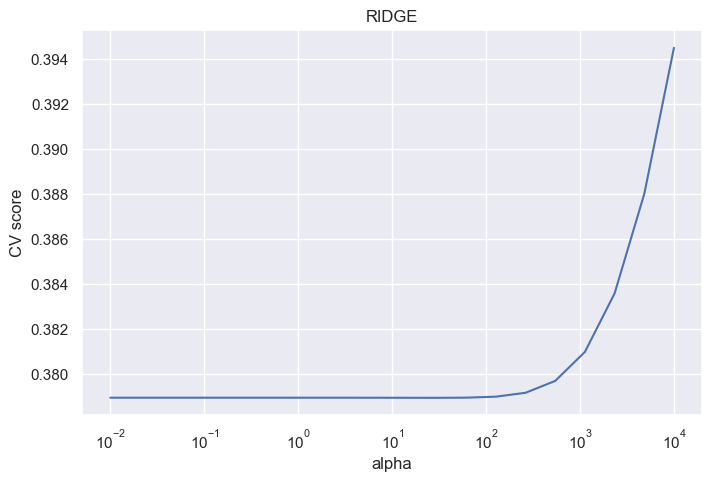

In [94]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_val[train_features], y_val)

best_alpha_ridge = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha_ridge)

plt.title('RIDGE')
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [96]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.2490
Size before OneHot: (766046, 19)
Size after OneHot: (766046, 220)


Best alpha = 0.0100


Text(0, 0.5, 'CV score')

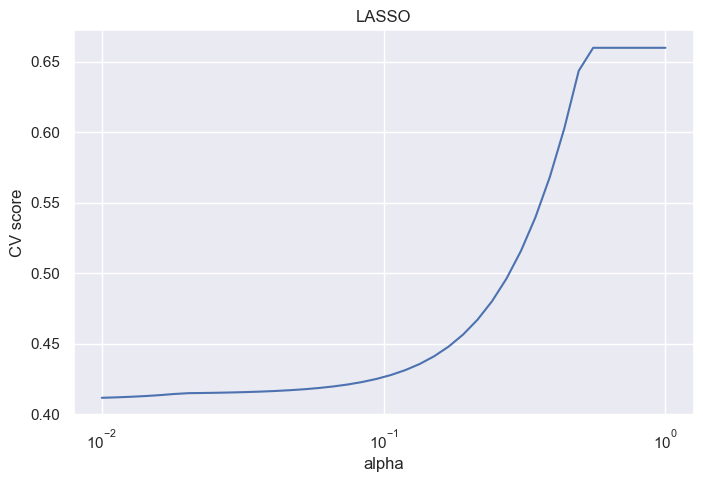

In [97]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 0, 40)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_val[train_features], y_val)

best_alpha_lasso = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha_lasso)

plt.title('LASSO')
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [99]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = lasso_pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.2741
Size before OneHot: (766046, 19)
Size after OneHot: (766046, 220)


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

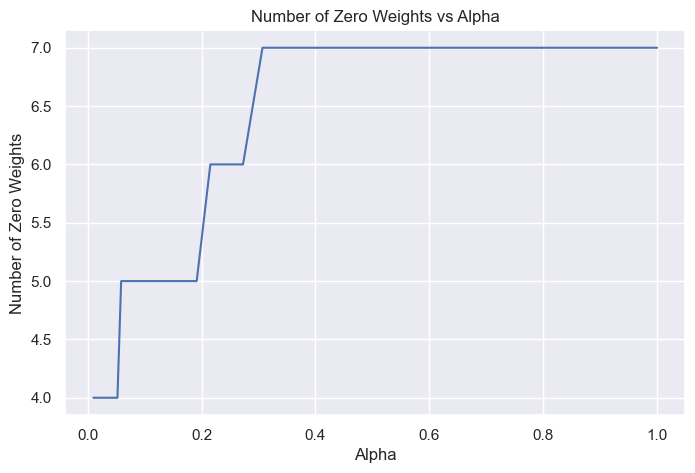

In [100]:
zero_weights = []
mse_s = []
alphas = np.logspace(-2, 0, 40)
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train[train_features], y_train)
    mse_s.append(mean_squared_error(y_test, lasso.predict(X_test[train_features])))
    zero_weights.append(np.sum(lasso.coef_ == 0))

plt.plot(alphas, zero_weights)
plt.xlabel('Alpha')
plt.ylabel('Number of Zero Weights')
plt.title('Number of Zero Weights vs Alpha')
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [105]:
X_train = train_transform.transform(X_train)
X_test = train_transform.transform(X_test)

# Подготавливаем данные 
from_to_features = X_train.groupby(['pickup_area','dropoff_area']).count().iloc[:,0].reset_index()
from_to_features.columns = ['pickup_area','dropoff_area','passenger_count']
from_to_features = from_to_features.sort_values(by = 'passenger_count',ascending=False)[:100]
from_to_features['position'] = np.array(range(100,0,-1))

def get_pair_cat(row):
    """
    В зависимости от пары зона начала/конца поездки подберем дополнительный признак
    """
    pick = row['pickup_area']
    drop = row['dropoff_area']
    pos = from_to_features[(from_to_features['pickup_area'] == pick) & (from_to_features['dropoff_area'] == drop)]['position']
    if  pos.empty:
        return -1
    else:
        return pos.values[0]

X_train['position'] = X_train.loc[:,['pickup_area','dropoff_area']].apply(get_pair_cat,axis = 1)

In [106]:
# Подготавливаем данные 
from_to_features = X_train.groupby(['pickup_area','dropoff_area']).count().iloc[:,0].reset_index()
from_to_features.columns = ['pickup_area','dropoff_area','passenger_count']
from_to_features = from_to_features.sort_values(by = 'passenger_count',ascending=False)[:100]
from_to_features['position'] = np.array(range(100,0,-1))

In [107]:
def get_pair_cat(row):
    """
    В зависимости от пары зона начала/конца поездки подберем дополнительный признак
    """
    pick = row['pickup_area']
    drop = row['dropoff_area']
    pos = from_to_features[(from_to_features['pickup_area'] == pick) & (from_to_features['dropoff_area'] == drop)]['position']
    if  pos.empty:
        return -1
    else:
        return pos.values[0]

In [113]:
# X_train['position'] = X_train.loc[:,['pickup_area','dropoff_area']].apply(get_pair_cat,axis = 1)
from_to_features_dict = from_to_features.set_index(['pickup_area', 'dropoff_area'])['position'].to_dict()
X_train['position'] = X_train[['pickup_area', 'dropoff_area']].apply(lambda row: from_to_features_dict.get((row['pickup_area'], row['dropoff_area']), -1), axis=1)
X_test['position'] = X_test[['pickup_area', 'dropoff_area']].apply(lambda row: from_to_features_dict.get((row['pickup_area'], row['dropoff_area']), -1), axis=1)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [115]:
numeric_features = ['log_haversine']
categorical_features = ['weekday', 'hour',
                         'month', 'dayofyear', 'pickup_area', 'dropoff_area', 'position']
train_features = ['weekday', 'hour', 'month', 'dayofyear', 'is_anomaly',
       'log_haversine', 'is_jam', 'airports', 'pickup_area', 'dropoff_area', 'position']



column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train[train_features], y_train)
y_pred = model.predict(X_test[train_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Test RMSE = 0.2245
Size before OneHot: (766046, 22)
Size after OneHot: (766046, 354)


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.